**AirBnB** is a marketplace for short term rentals that allows us to list part or all of our living space for others to rent. We can rent everything from a room in an apartment to our entire house on AirBnB. 

Because most of the listings are on a short-term basis, **AirBnB** has grown to become a popular alternative to hotels. The company itself has grown from it's founding in 2008 to a 30 billion dollar [valuation in 2016](https://www.bloomberg.com/news/articles/2016-08-05/airbnb-files-to-raise-850-million-at-30-billion-valuation) and is currently worth more than any hotel chain in the world.

One challenge that hosts looking to rent their living space face is determining the optimal nightly rent price. In many areas, renters are presented with a good selection of listings and can filter on criteria like 
* price, 
* number of bedrooms, 
* room type and more. 

Since **AirBnB** is a marketplace, the amount a host can charge on a nightly basis is closely linked to the dynamics of the marketplace. 

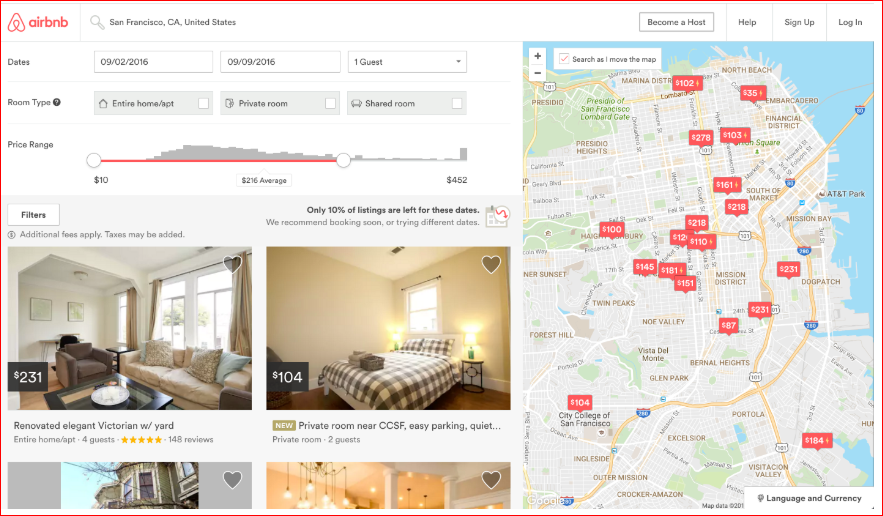

As a host, if we try to charge above market price for a living space we'd like to rent, then renters will select more affordable alternatives which are similar to ours. If we set our nightly rent price too low, we'll miss out on potential revenue.

One strategy we could use is to:

* find a few listings that are similar to ours,
* average the listed price for the ones most similar to ours,
* set our listing price to this calculated average price.

The process of discovering patterns in existing data to make a prediction is called **machine learning**. In our case, we want to use data on local listings to predict the optimal price for us to set.

We'll explore a specific machine learning technique called **k-nearest neighbors**, which mirrors the strategy we just described.

While AirBnB doesn't release any data on the listings in their marketplace, a separate group named [Inside AirBnB](http://insideairbnb.com/get-the-data.html) has extracted data on a sample of the listings for many of the major cities on the website. In this post, we'll be working with their dataset from October 3, 2015 on the listings from Washington, D.C., the capital of the United States.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image

dc_listings = pd.read_csv("dc_airbnb.csv")
dc_listings.head(3)

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,room_type,bedrooms,bathrooms,beds,price,cleaning_fee,security_deposit,minimum_nights,maximum_nights,number_of_reviews,latitude,longitude,city,zipcode,state
0,92%,91%,26,4,Entire home/apt,1.0,1.0,2.0,$160.00,$115.00,$100.00,1,1125,0,38.890046,-77.002808,Washington,20003,DC
1,90%,100%,1,6,Entire home/apt,3.0,3.0,3.0,$350.00,$100.00,NaN,2,30,65,38.880413,-76.990485,Washington,20003,DC
2,90%,100%,2,1,Private room,1.0,2.0,1.0,$50.00,NaN,NaN,2,1125,1,38.955291,-76.986006,Hyattsville,20782,MD


Each row in the dataset is a specific listing that's available for renting on AirBnB in the Washington, D.C. area.

* `host_response_rate`: the response rate of the host
* `host_acceptance_rate`: number of requests to the host that convert to rentals
* `host_listings_count`: number of other listings the host has
* `latitude`: latitude dimension of the geographic coordinates
* `longitude`: longitude part of the coordinates
* `city`: the city the living space resides
* `zipcode`: the zip code the living space resides
* `state`: the state the living space resides
* `accommodates`: the number of guests the rental can accommodate
* `room_type`: the type of living space (`Private room`, `Shared room` or `Entire home/apt`)
* `bedrooms`: number of bedrooms included in the rental
* `bathrooms`: number of bathrooms included in the rental
* `beds`: number of beds included in the rental
* `price`: nightly price for the rental
* `cleaning_fee`: additional fee used for cleaning the living space after the guest leaves
* `security_deposit`: refundable security deposit, in case of damages
* `minimum_nights`: minimum number of nights a guest can stay for the rental
* `maximum_nights`: maximum number of nights a guest can stay for the rental
* `number_of_reviews`: number of reviews that previous guests have left

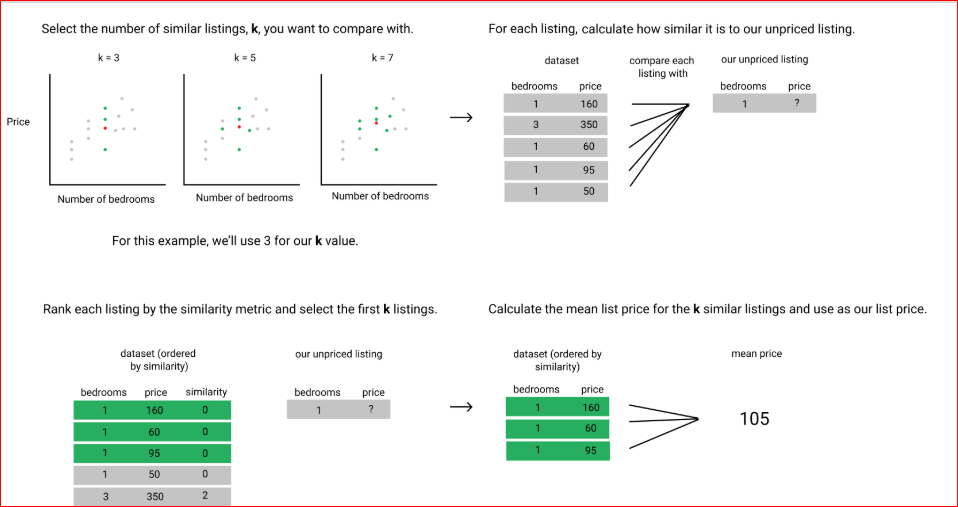

There are 2 things we need to unpack in more detail:

* the similarity metric
* how to choose the `k` value

We'll use a `k` value of 5

The similarity metric works by comparing a fixed set of numerical features, another word for attributes, between **2 observations**, or living spaces in our case. When trying to predict a continuous value, like price, the main similarity metric that's used is **Euclidean distance**.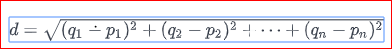

where $q_1$ to $q_n$ represent the feature values for one observation and $p_1$ to $p_n$  represent the feature values for the other observation

Here's a diagram that breaks down the Euclidean distance between the first 2 observations in the dataset using only the `host_listings_count`, `accommodates`, `bedrooms`, `bathrooms`, and `beds` columns: 

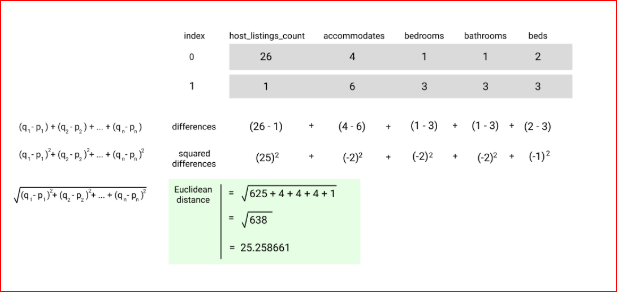

In this project, we'll use just one feature to keep things simple as we become familiar with the machine learning workflow. Since we're only using one feature, this is known as the **univariate case**.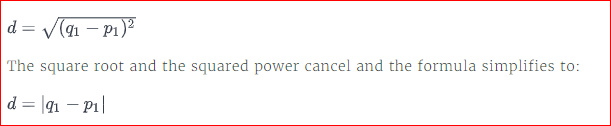

The living space that we want to rent can accommodate 3 people. Let's first calculate the distance, using just the accommodates feature, between the first living space in the dataset and our own.

In [2]:
# Calculate the Euclidean distance between our living space, which can accommodate 3 people, 
# and the first living space in the dc_listings Dataframe.

our_acc_value = 3
first_living_space_value = dc_listings["accommodates"][0]

first_distance = np.abs(our_acc_value - first_living_space_value)
first_distance


1

The Euclidean distance between the first row in the `dc_listings` Dataframe and our own living space is `1`. 

How do we know if this is high or low? If we look at the Euclidean distance equation itself, the lowest value we can achieve is `0`. This happens when the value for the feature is exactly the same for both observations we're comparing. The closer to `0` the distance the more similar the living spaces are.

In [3]:
# Calculate the distance between each value in the accommodates column from dc_listings and
# the value 3, which is the number of people our listing accommodates:

temp_df = dc_listings.copy()
temp_df["distance"]  = temp_df["accommodates"].apply(lambda x: np.abs(our_acc_value - x))

temp_df["distance"].value_counts().sort_index()

0      461
1     2294
2      503
3      279
4       35
5       73
6       17
7       22
8        7
9       12
10       2
11       4
12       6
13       8
Name: distance, dtype: int64

It looks like there are quite a few, 461 to be precise, living spaces that can accommodate `3` people just like ours. This means the `5` **nearest neighbors** we select after sorting all will have a distance value of `0`. 

If we sort by the distance column and then just select the first `5` living spaces, we would be biasing the result to the ordering of the dataset.

Let's instead randomize the ordering of the dataset and then sort the Dataframe by the distance column. This way, all of the living spaces with the same number of bedrooms will still be at the top of the Dataframe but will be in random order across the first 461 rows

In [10]:
np.random.seed(1)

shuffle_index = np.random.permutation(temp_df.index) # or len(dc_listings)
shuffle_index

array([ 574, 1593, 3091, ..., 1096,  235, 1061], dtype=int64)

In [65]:
temp_df =temp_df.loc[shuffle_index,:].copy()
temp_df = temp_df.sort_values(by = "distance")
temp_df.head(10)

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,room_type,bedrooms,bathrooms,beds,price,cleaning_fee,security_deposit,minimum_nights,maximum_nights,number_of_reviews,latitude,longitude,city,zipcode,state,distance
577,98%,52%,49,3,Private room,1.0,1.0,2.0,$185.00,NaN,NaN,2,14,1,38.908356,-77.028146,Washington,20005,DC,0
2166,100%,89%,2,3,Entire home/apt,1.0,1.0,1.0,$180.00,NaN,$100.00,1,14,10,38.905808,-77.000012,Washington,20002,DC,0
3631,98%,52%,49,3,Entire home/apt,1.0,1.0,2.0,$175.00,NaN,NaN,3,14,1,38.889065,-76.993576,Washington,20003,DC,0
71,100%,94%,1,3,Entire home/apt,1.0,1.0,1.0,$128.00,$40.00,NaN,1,1125,9,38.879960,-77.006491,Washington,20003,DC,0
1011,NaN,NaN,1,3,Entire home/apt,0.0,1.0,1.0,$115.00,NaN,NaN,1,1125,0,38.907382,-77.035075,Washington,20005,DC,0
380,58%,51%,480,3,Entire home/apt,NaN,1.0,1.0,$219.00,NaN,NaN,4,1125,0,38.900820,-77.052956,Washington,20037,DC,0
943,NaN,NaN,1,3,Private room,1.0,1.0,1.0,$125.00,$25.00,NaN,1,1125,3,38.913882,-77.038468,Washington,20009,DC,0
3107,NaN,NaN,1,3,Entire home/apt,1.0,1.0,1.0,$250.00,NaN,NaN,1,1125,0,38.934027,-77.035193,Washington,20010,DC,0
1499,62%,77%,1,3,Entire home/apt,0.0,1.0,2.0,$94.00,NaN,NaN,1,1125,2,38.878030,-77.019914,Washington,20024,DC,0
625,100%,0%,1,3,Entire home/apt,1.0,1.0,1.0,$150.00,NaN,NaN,1,1125,5,38.907031,-77.029510,Washington,20005,DC,0


Before we can select the 5 most similar living spaces and compute the average price, we need to clean the price column. Right now, the price column contains **comma characters** (`,`) and **dollar sign** characters and is formatted as a text column instead of a numeric one

In [66]:
temp_df["price"] = temp_df["price"].str.replace("$","").str.replace(",","").astype(float) 

In [67]:
# Calculate the mean of the first 5 values in the price column

mean_price = temp_df["price"].head().mean()
mean_price

156.6

Based on the average price of other listings that accommdate `3` people, we should charge `156.6` dollars per night for a guest to stay at our living space.

In [74]:
# function named predict_price that can use the k-nearest neighbors machine learning technique
# to calculate the suggested price for any value for accommodates

def predict_price(new_listing):
    np.random.seed(1)
    new_df = dc_listings.copy()
    new_df["distance"] = new_df["accommodates"].apply(lambda x : np.abs(new_listing - x))
    shuffle_index = np.random.permutation(new_df.index)
    new_df = new_df.loc[shuffle_index,:]
    new_df = new_df.sort_values("distance")
    new_df["price"]= new_df["price"].str.replace("$","").str.replace(",","").astype(float)
    nearest_neighbors = new_df["price"].head()
    predicted_price = nearest_neighbors.mean()
    return predicted_price

In [77]:
# price for a living space 3
predict_price(3)

# price for a living space 2
predict_price(2)

# price for a living space 4
predict_price(4)

124.8

We explored the problem of predicting the optimal price to list an **AirBnB** rental based on the price of similar listings on the site. We stepped through the entire machine learning workflow, from selecting a feature to testing the model. 

To explore the basics of machine learning, we limited ourselves to only using one feature (the univariate case) and a fixed **k** value of `5`.